# Ice thickness inversion

This example shows how to run the OGGM ice thickness inversion model
with various ice parameters: the deformation parameter A and a sliding
parameter (fs).

There is currently no "best" set of parameters for the ice thickness
inversion model. As shown in
[Maussion et al. (2019)](https://www.geosci-model-dev.net/12/909/2019/),
the default parameter set results in global volume estimates which are a bit
larger than previous values. For the consensus estimate of
[Farinotti et al. (2019)](https://www.nature.com/articles/s41561-019-0300-3),
OGGM participated with a deformation parameter A that is 1.5 times larger than the
generally accepted default value.

There is no reason to think that the ice parameters are the same between
neighboring glaciers. There is currently no "good" way to calibrate them,
or at least no generaly accepted one.
We won't discuss the details here, but we provide a script to illustrate
the sensitivity of the model to this choice.

**New in version 1.4**: we demonstrate how to apply a new global task in OGGM, `workflow.calibrate_inversion_from_consensus` to calibrate the A parameter to match the consensus estimate from [Farinotti et al. (2019)](https://www.nature.com/articles/s41561-019-0300-3).

At the end of this tutorial, we show how to distribute the "flowline thicknesses" on a glacier map.

## Run

In [1]:
# Libs
import geopandas as gpd

# Locals
import oggm.cfg as cfg
from oggm import utils, workflow, tasks, graphics

# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WARNING')
rgi_region = '11'  # Region Central Europe

# Local working directory (where OGGM will write its output)
WORKING_DIR = utils.gettempdir('OGGM_Inversion')
utils.mkdir(WORKING_DIR, reset=True)
cfg.PATHS['working_dir'] = WORKING_DIR

# This is useful here
cfg.PARAMS['use_multiprocessing'] = True

# RGI file
path = utils.get_rgi_region_file(rgi_region)
rgidf = gpd.read_file(path)

# Select the glaciers in the Pyrenees
rgidf = rgidf.loc[rgidf['O2Region'] == '2']

# Sort for more efficient parallel computing
rgidf = rgidf.sort_values('Area', ascending=False)

# Go - get the pre-processed glacier directories
# We start at level 3, because we need all data for the inversion
gdirs = workflow.init_glacier_directories(rgidf, from_prepro_level=3, prepro_border=10)

# Because of recent changes in OGGM not yet available in the preprocessed directories, 
# we re-run this task:
workflow.execute_entity_task(tasks.prepare_for_inversion, gdirs)

# Default parameters
# Deformation: from Cuffey and Patterson 2010
glen_a = 2.4e-24
# Sliding: from Oerlemans 1997
fs = 5.7e-20

2021-06-02 22:24:04: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-06-02 22:24:04: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-06-02 22:24:04: oggm.cfg: Multiprocessing: using all available processors (N=72)
2021-06-02 22:24:04: oggm.cfg: Multiprocessing switched ON after user settings.
2021-06-02 22:24:05: oggm.workflow: init_glacier_directories from prepro level 3 on 35 glaciers.
2021-06-02 22:24:05: oggm.workflow: Execute entity task gdir_from_prepro on 35 glaciers
100% of  45.1 MiB |######################| Elapsed Time: 0:00:04 Time:  0:00:04
2021-06-02 22:24:11: oggm.workflow: Execute entity task prepare_for_inversion on 35 glaciers


In [2]:
with utils.DisableLogger():  # this scraps some output - to use with caution!!!
    
    # Correction factors
    factors = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    factors += [1.1, 1.2, 1.3, 1.5, 1.7, 2, 2.5, 3, 4, 5]
    factors += [6, 7, 8, 9, 10]

    # Run the inversions tasks with the given factors
    for f in factors:
        # Without sliding
        suf = '_{:03d}_without_fs'.format(int(f * 10))
        workflow.execute_entity_task(tasks.mass_conservation_inversion, gdirs,
                                     glen_a=glen_a*f, fs=0)
        # Store the results of the inversion only
        utils.compile_glacier_statistics(gdirs, filesuffix=suf,
                                         inversion_only=True)

        # With sliding
        suf = '_{:03d}_with_fs'.format(int(f * 10))
        workflow.execute_entity_task(tasks.mass_conservation_inversion, gdirs,
                                     glen_a=glen_a*f, fs=fs)
        # Store the results of the inversion only
        utils.compile_glacier_statistics(gdirs, filesuffix=suf,
                                         inversion_only=True)

## Read the data

The data are stored as csv files in the working directory. The easiest way to read them is to use [pandas](http://pandas.pydata.org/)!

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import os

Let's read the output of the inversion with the default OGGM parameters first:

In [4]:
df = pd.read_csv(os.path.join(WORKING_DIR, 'glacier_statistics_011_without_fs.csv'), index_col=0)
df

,rgi_region,rgi_subregion,name,cenlon,cenlat,rgi_area_km2,rgi_year,glacier_type,terminus_type,is_tidewater,...,inv_volume_km3,vas_volume_km3,inv_volume_bsl_km3,inv_volume_bwl_km3,dem_source,n_orig_centerlines,flowline_type,perc_invalid_flowline,inversion_glen_a,inversion_fs
rgi_id,,,,,,,,,,,,,,,,,,,,,
RGI60-11.03208,11,11-02,Aneto,0.646032,42.641357,0.622,2011,Glacier,Land-terminating,False,...,0.029854,0.017699,0.0,0.0,NASADEM,2,centerlines,0.205128,2.640000e-24,0
RGI60-11.03232,11,11-02,Ossoue,-0.141222,42.771191,0.449,2011,Glacier,Land-terminating,False,...,0.019636,0.011306,0.0,0.0,NASADEM,1,centerlines,0.000000,2.640000e-24,0
RGI60-11.03222,11,11-02,Monte Perdido Lower,0.039655,42.679337,0.308,2011,Glacier,Land-terminating,False,...,0.009120,0.006733,0.0,0.0,NASADEM,2,centerlines,0.000000,2.640000e-24,0
RGI60-11.03209,11,11-02,Maladeta E,0.639343,42.648979,0.260,2011,Glacier,Land-terminating,False,...,0.007672,0.005334,0.0,0.0,NASADEM,1,centerlines,0.000000,2.640000e-24,0
RGI60-11.03231,11,11-02,Oulettes Du Gaube,-0.144215,42.779716,0.130,2011,Glacier,Land-terminating,False,...,0.002747,0.002057,0.0,0.0,NASADEM,1,centerlines,0.000000,2.640000e-24,0
RGI60-11.03213,11,11-02,Seil De La Baque E,0.494304,42.694481,0.105,2011,Glacier,Land-terminating,False,...,0.002118,0.001533,0.0,0.0,NASADEM,1,centerlines,0.000000,2.640000e-24,0
RGI60-11.03239,11,11-02,Jezerces Gl No1,19.807627,42.465839,0.097,2007,Glacier,Land-terminating,False,...,0.002538,0.001375,0.0,0.0,NASADEM,1,centerlines,0.562500,2.640000e-24,0
RGI60-11.03229,11,11-02,Gabietous,-0.057456,42.695129,0.087,2011,Glacier,Land-terminating,False,...,0.001720,0.001184,0.0,0.0,NASADEM,1,centerlines,0.000000,2.640000e-24,0
RGI60-11.03218,11,11-02,Llardana,0.428193,42.653946,0.084,2011,Glacier,Land-terminating,False,...,0.001472,0.001128,0.0,0.0,NASADEM,1,centerlines,0.000000,2.640000e-24,0


There are only 35 glaciers in the Pyrenees! That's why the run was relatively fast.

## Results

One way to visualize the output is to plot the volume as a function of area in a log-log plot, illustrating the well known volume-area relationship of mountain glaciers:

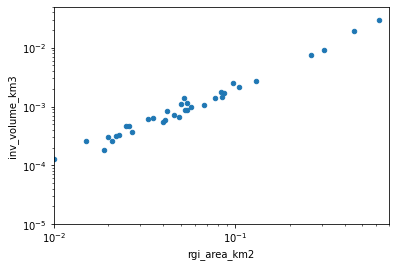

In [5]:
ax = df.plot(kind='scatter', x='rgi_area_km2', y='inv_volume_km3')
ax.semilogx(); ax.semilogy()
xlim, ylim = [1e-2, 0.7], [1e-5, 0.05]
ax.set_xlim(xlim); ax.set_ylim(ylim);

As we can see, there is a clear relationship, but it is not perfect. Let's fit a line to these data (the "volume-area scaling law"):

In [6]:
# Fit in log space 
dfl = np.log(df[['inv_volume_km3', 'rgi_area_km2']])
slope, intercept, r_value, p_value, std_err = stats.linregress(dfl.rgi_area_km2.values, dfl.inv_volume_km3.values)

In their seminal paper, [Bahr et al. (1997)](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/97JB01696) describe this relationship as:

$$V = \alpha S^{\gamma}$$

With V the volume in km$^3$, S the area in km$^2$ and $\alpha$ and $\gamma$ the scaling parameters (0.034 and 1.375, respectively). How does OGGM compare to these in the Pyrenees?

In [7]:
print('power: {:.3f}'.format(slope))
print('slope: {:.3f}'.format(np.exp(intercept)))

power: 1.301
slope: 0.045


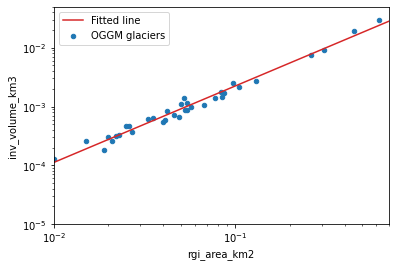

In [8]:
ax = df.plot(kind='scatter', x='rgi_area_km2', y='inv_volume_km3', label='OGGM glaciers')
ax.plot(xlim, np.exp(intercept) * (xlim ** slope), color='C3', label='Fitted line')
ax.semilogx(); ax.semilogy()
ax.set_xlim(xlim); ax.set_ylim(ylim);
ax.legend();

## Sensitivity analysis 

Now, let's read the output files of each run separately, and compute the regional volume out of them:

In [9]:
dftot = pd.DataFrame(index=factors)
for f in factors:
    # Without sliding
    suf = '_{:03d}_without_fs'.format(int(f * 10))
    fpath = os.path.join(WORKING_DIR, 'glacier_statistics{}.csv'.format(suf))
    _df = pd.read_csv(fpath, index_col=0, low_memory=False)
    dftot.loc[f, 'without_sliding'] = _df.inv_volume_km3.sum()
    
    # With sliding
    suf = '_{:03d}_with_fs'.format(int(f * 10))
    fpath = os.path.join(WORKING_DIR, 'glacier_statistics{}.csv'.format(suf))
    _df = pd.read_csv(fpath, index_col=0, low_memory=False)
    dftot.loc[f, 'with_sliding'] = _df.inv_volume_km3.sum()

And plot them:

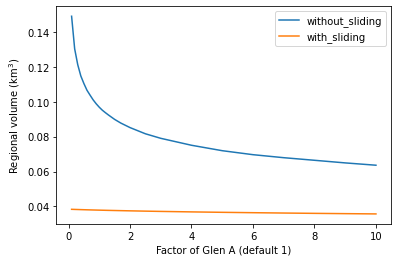

In [10]:
dftot.plot();
plt.xlabel('Factor of Glen A (default 1)'); plt.ylabel('Regional volume (km$^3$)');

As you can see, there is quite a difference between the solutions. In particular, close to the default value for Glen A, the regional estimates are very sensitive to small changes in A. The calibration of A is a problem that has yet to be resolved by global glacier models...

## New in version 1.4: calibrate to match the consensus estimate 

Here, a "best Glen A" is found in order that the total inverted volume of the glaciers of gdirs fits to the 2019 consensus estimate. 

In [11]:
cdf = workflow.calibrate_inversion_from_consensus(gdirs, filter_inversion_output=False)

2021-06-02 22:24:30: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 35 glaciers
2021-06-02 22:24:30: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-06-02 22:24:30: oggm.workflow: Applying global task inversion_tasks on 35 glaciers
2021-06-02 22:24:30: oggm.workflow: Execute entity task prepare_for_inversion on 35 glaciers
2021-06-02 22:24:30: oggm.workflow: Execute entity task mass_conservation_inversion on 35 glaciers
2021-06-02 22:24:30: oggm.workflow: Execute entity task get_inversion_volume on 35 glaciers
2021-06-02 22:24:30: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-06-02 22:24:30: oggm.workflow: Applying global task inversion_tasks on 35 glaciers
2021-06-02 22:24:30: oggm.workflow: Execute entity task prepare_for_inversion on 35 glaciers
2021-06-02 22:24:30: oggm.workflow: Execute entity task mass_conservation_inversion on 35 glaciers
2021-06-02 22:24:30: oggm.workflow: Execute en

In [12]:
cdf.sum()

vol_itmix_m3        6.423913e+07
vol_bsl_itmix_m3    0.000000e+00
vol_oggm_m3         6.425211e+07
dtype: float64

Note that here we calibrate the Glen A parameter to a value that is equal for all glaciers of gdirs (here $A \sim 9.504\cdot A_0$), i.e. we calibrate to match the total volume of all glaciers and not to match them individually.

In [13]:
cdf.iloc[:3]

,vol_itmix_m3,vol_bsl_itmix_m3,vol_oggm_m3
RGIId,,,
RGI60-11.03208,1.564802e+07,0.0,1.972692e+07
RGI60-11.03232,1.422478e+07,0.0,1.340392e+07
RGI60-11.03222,5.158277e+06,0.0,6.604405e+06


*just as a side note, "vol_bsl_itmix_m3" means volume below sea level and is therefore zero for these Alpine glaciers!*

## Distributed ice thickness 

The OGGM inversion and dynamical models use the "1D" flowline assumption: for some applications, you might want to use OGGM to create distributed ice thickness maps. Currently, OGGM implements two ways to "distribute" the flowline thicknesses, but only [the simplest one](https://docs.oggm.org/en/stable/generated/oggm.tasks.distribute_thickness_per_altitude.html) works robustly:

In [14]:
# Distribute
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);

2021-06-02 22:24:31: oggm.workflow: Execute entity task distribute_thickness_per_altitude on 35 glaciers


We just created a new output of the model, which we can access in the `gridded_data` file: 

In [15]:
# xarray is an awesome library! Did you know about it?
import xarray as xr
ds = xr.open_dataset(gdirs[0].get_filepath('gridded_data'))

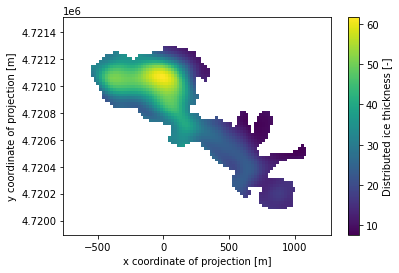

In [16]:
ds.distributed_thickness.plot();

Since some people more like to operate `geotiff` data format than `netCDF`. OGGM also provide a tool to save the variabel in the `gridded_data.nc` file to a `geotiff` file:

In [17]:
# We try to save the distributed ice thickness in to a geotiff file
workflow.execute_entity_task(tasks.gridded_data_var_to_geotiff, gdirs, varname='distributed_thickness')

# The defualt path of the geotiff file is in the glacier directory with the name "distributed_thickness.tif"
# Let's check if the file exists
for gdir in gdirs:
    path = os.path.join(gdir.dir, 'distributed_thickness.tif')
    if os.path.exists(path):
        print(f"{gdir.rgi_id}: Find 'distributed_thickness.tif'!")
    else:
        print(f"{gdir.rgi_id}: Don't find 'distributed_thickness.tif'!")

2021-06-02 22:24:32: oggm.workflow: Execute entity task gridded_data_var_to_geotiff on 35 glaciers
RGI60-11.03208: Find 'distributed_thickness.tif'!
RGI60-11.03232: Find 'distributed_thickness.tif'!
RGI60-11.03222: Find 'distributed_thickness.tif'!
RGI60-11.03209: Find 'distributed_thickness.tif'!
RGI60-11.03231: Find 'distributed_thickness.tif'!
RGI60-11.03213: Find 'distributed_thickness.tif'!
RGI60-11.03239: Find 'distributed_thickness.tif'!
RGI60-11.03229: Find 'distributed_thickness.tif'!
RGI60-11.03218: Find 'distributed_thickness.tif'!
RGI60-11.03228: Find 'distributed_thickness.tif'!
RGI60-11.03205: Find 'distributed_thickness.tif'!
RGI60-11.03206: Find 'distributed_thickness.tif'!
RGI60-11.03217: Find 'distributed_thickness.tif'!
RGI60-11.03221: Find 'distributed_thickness.tif'!
RGI60-11.03210: Find 'distributed_thickness.tif'!
RGI60-11.03233: Find 'distributed_thickness.tif'!
RGI60-11.03225: Find 'distributed_thickness.tif'!
RGI60-11.03211: Find 'distributed_thickness.tif'!
R

In fact, `tasks.gridded_data_var_to_geotiff()` can save any variable in the `gridded_data.nc` file. The `geotiff` is named as the variable name with a `.tif` suffix. Have a try by yourself ;-)

## Plot many glaciers on a map 

Let's select a group of glaciers close to each other: 

In [18]:
rgi_ids = ['RGI60-11.0{}'.format(i) for i in range(3205, 3211)]
sel_gdirs = [gdir for gdir in gdirs if gdir.rgi_id in rgi_ids]
graphics.plot_googlemap(sel_gdirs)
# you might need to install motionless if it is not yet in your environment

URLError: <urlopen error [Errno 104] Connection reset by peer>

### Using OGGM 

Since [a recent PR (21.05.2020)](https://github.com/OGGM/oggm/pull/1025), OGGM can plot the thickness of a group of glaciers on a map:

In [ ]:
graphics.plot_distributed_thickness(sel_gdirs)

This is however not very useful because OGGM can only plot on a map as large as the local glacier map of the first glacier in the list. See [this issue](https://github.com/OGGM/oggm/issues/1007) for a discussion about why.

### Using salem 

Under the hood, OGGM uses [salem](https://salem.readthedocs.io) to make the plots. Let's do that for our case: it requires some manual tweaking, but it should be possible to automatize this better in the future.

*Note: this also requires a very recent version of salem to work (21.05.2020)*

In [ ]:
import salem
# Make a grid covering the desired map extent
g = salem.mercator_grid(center_ll=(0.65, 42.64), extent=(4000, 4000))
# Create a map out of it
smap = salem.Map(g, countries=False)
# Add the glaciers outlines
for gdir in sel_gdirs:
    crs = gdir.grid.center_grid
    geom = gdir.read_pickle('geometries')
    poly_pix = geom['polygon_pix']
    smap.set_geometry(poly_pix, crs=crs, fc='none', zorder=2, linewidth=.2)
    for l in poly_pix.interiors:
        smap.set_geometry(l, crs=crs, color='black', linewidth=0.5)
f, ax = plt.subplots(figsize=(6, 6))
smap.visualize();

In [ ]:
# Now add the thickness data
for gdir in sel_gdirs:
    grids_file = gdir.get_filepath('gridded_data')
    with utils.ncDataset(grids_file) as nc:
        vn = 'distributed_thickness'
        thick = nc.variables[vn][:]
        mask = nc.variables['glacier_mask'][:]
    thick = np.where(mask, thick, np.NaN)
    # The "overplot=True" is key here
    # this needs a recent version of salem to run properly
    smap.set_data(thick, crs=gdir.grid.center_grid, overplot=True)

In [ ]:
# Set colorscale and other things
smap.set_cmap(graphics.OGGM_CMAPS['glacier_thickness'])
smap.set_plot_params(nlevels=256)
# Plot
f, ax = plt.subplots(figsize=(6, 6))
smap.visualize(ax=ax, cbar_title='Glacier thickness (m)');

## What's next?

- return to the [OGGM documentation](https://docs.oggm.org)
- back to the [table of contents](welcome.ipynb)